# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.

# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.neighbors import NearestNeighbors
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from IPython.display import display
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score
)
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

## Carga de datos

In [2]:
df = pd.read_csv('datasets/insurance_us.csv')

In [3]:
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
#Funcion para pasar columnas al formato snake_case
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s1 = s1.replace(' ','_')
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [5]:
#Pasamos las columnas al modo snake_case
columns=df.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df.columns=new_cols
print(df.columns)

Index(['gender', 'age', 'salary', 'family_members', 'insurance_benefits'], dtype='object')


In [6]:
df.describe()

,gender,age,salary,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Al realizar la revisión de los datos, se ve todo completo, sin valores ausentes, sin embargo, haremos la limpieza para ver que porcentaje de ausentes y duplicados tenemos. 

## Limpieza de datos

### Ausentes

In [7]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',100*df.isna().sum()/df.shape[0])

Porcentaje de significancia: 
 gender                0.0
age                   0.0
salary                0.0
family_members        0.0
insurance_benefits    0.0
dtype: float64


No se presentan ausentes en el dataset.

### Duplicados

In [8]:
print('Duplicados: \n',df.duplicated().sum())

Duplicados: 
 153


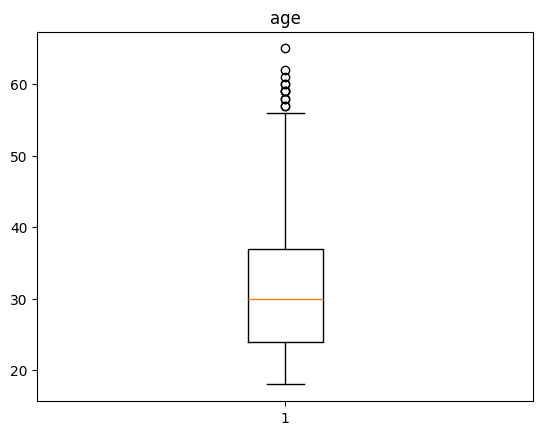

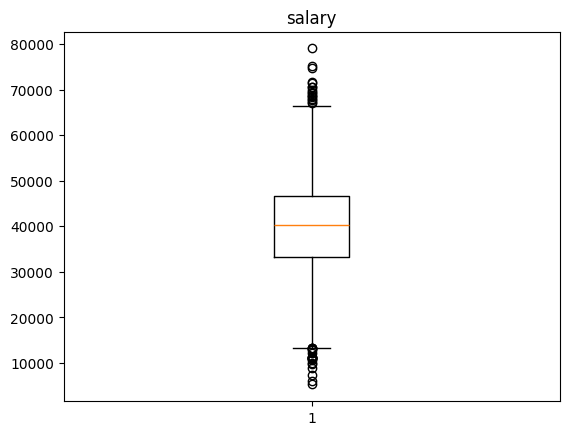

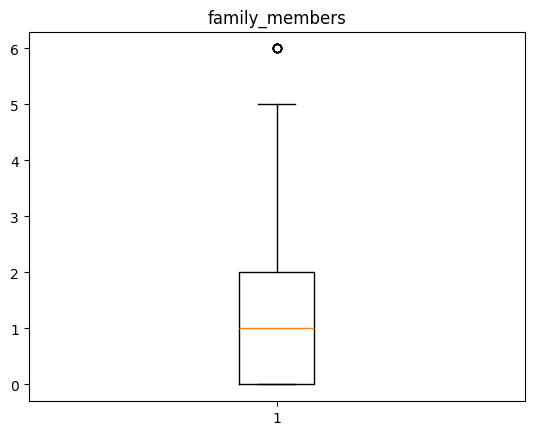

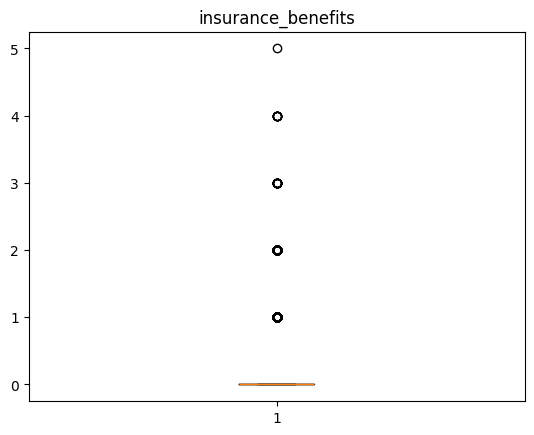

In [9]:
numeric=['age', 'salary', 'family_members', 'insurance_benefits']
for column in numeric:
    plt.boxplot(df[column])
    plt.title(column)   
    plt.show()

Podemos ver que tenemos valores atipicos por encima de 56 años y los salarios menores a 10000 y mayores a 67000, por lo tanto trabajaremos excluyendo estos datos.

In [10]:
#Segmentamos datos
df_copy=df.copy()
data=df_copy[(df_copy['age']<56)&((df_copy['salary']<67000)&(df_copy['salary']>10000))]

In [11]:
df_gender=df.copy()
df_gender['gender']=df_gender['gender'].astype('str')
px.histogram(df_gender['gender'])

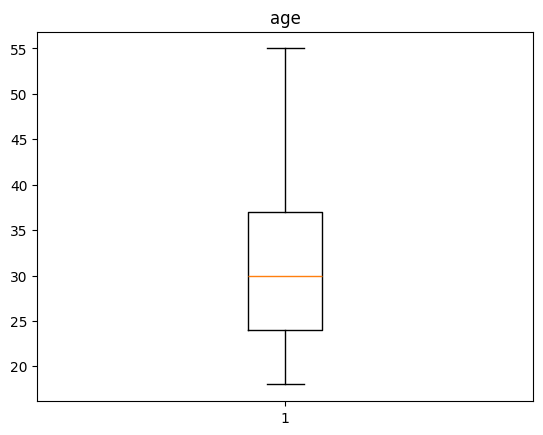

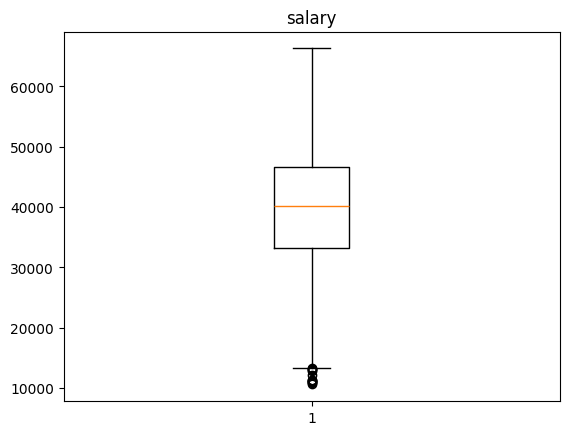

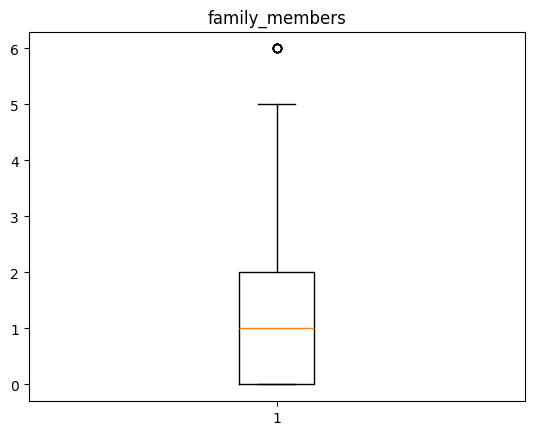

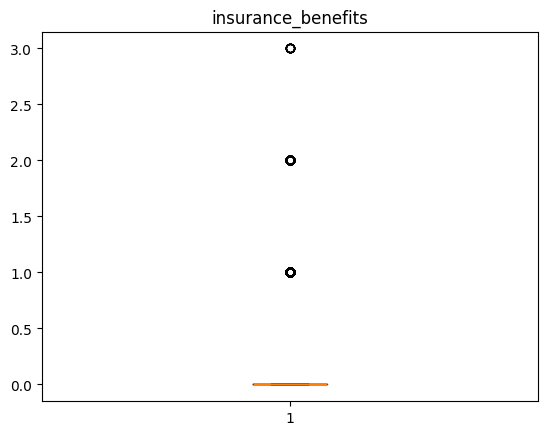

In [12]:
for column in numeric:
    plt.boxplot(data[column])
    plt.title(column)   
    plt.show()

## Análisis de datos

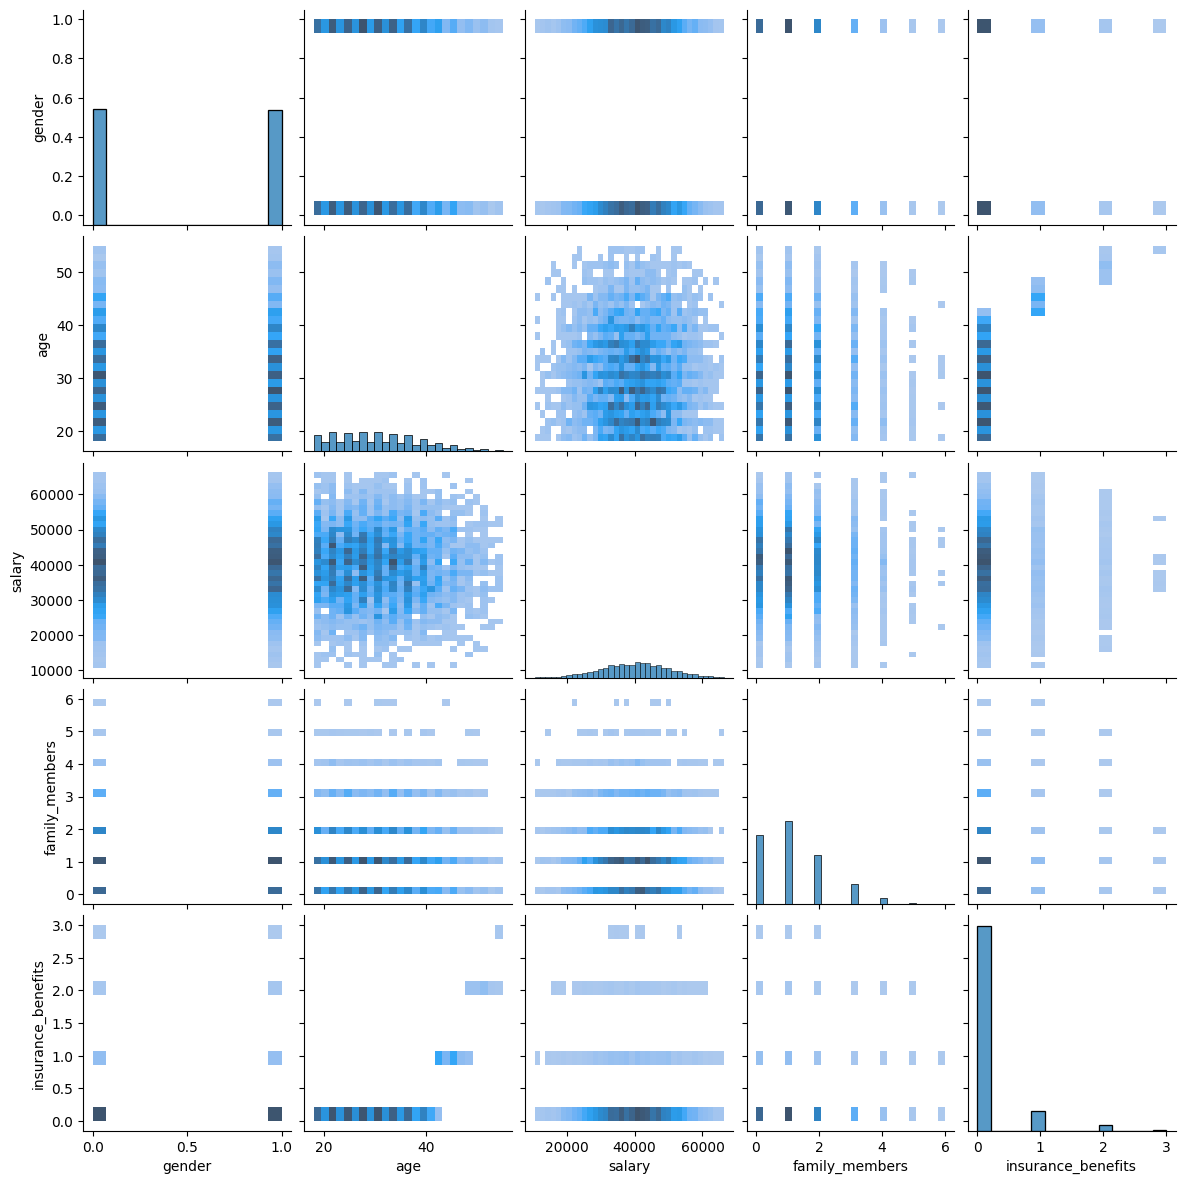

In [13]:
g = sns.pairplot(data, kind='hist')
g.fig.set_size_inches(12, 12)

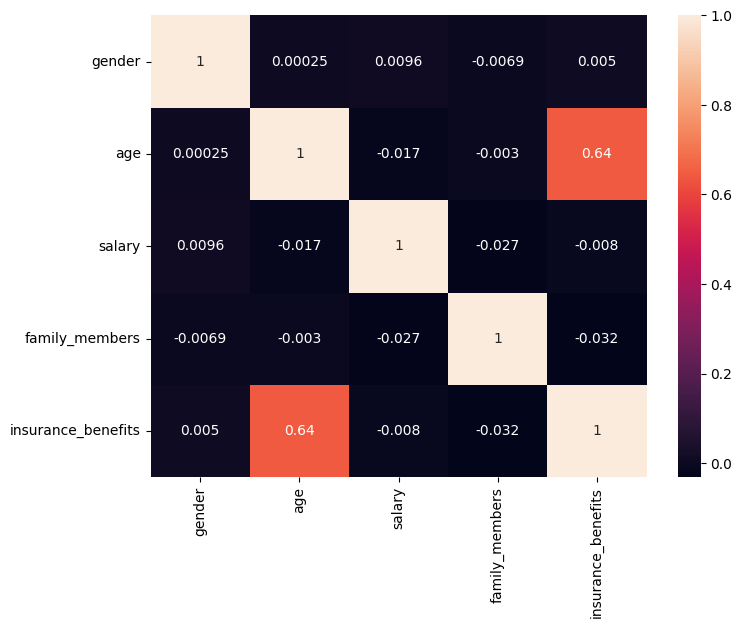

In [14]:
corr_df = data.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

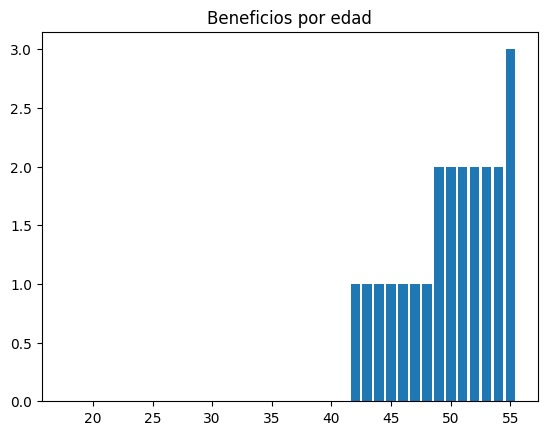

In [15]:
plt.bar(data['age'],data['insurance_benefits'])
plt.title('Beneficios por edad')
plt.show()

In [16]:
fig_1=px.histogram(data,x='age',y='family_members',color='gender',barmode='group')
fig_1.show()

In [17]:
fig_1=px.histogram(data,x='age',y='salary',color='gender',barmode='group')
fig_1.show()

In [18]:
fig_1=px.histogram(data,x='family_members',y='insurance_benefits',color='gender',barmode='group')
fig_1.show()

Podemos hacer las siguientes conclusiones con base al análisis exploratorio de datos:

1. Las variables con correlación leve son la edad y el numero de beneficios del seguro, donde a medida que la edad aumenta, los beneficios aumentan.

2. Podemos concluir que el salario y el número de miembros de la familia disminuye a medida que aumenta la edad.

3. El número de beneficios disminuye cuando se tienen más de un familiar.

## Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos. Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana

Distancia entre vectores -> Distancia Manhattan
Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un  𝑛𝑡ℎ
  objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas. Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta el enlace) o tu propia implementación. Pruébalo para cuatro combinaciones de dos casos- Escalado

los datos no están escalados
los datos se escalan con el escalador MaxAbsScaler
Métricas de distancia
Euclidiana
Manhattan
Responde a estas preguntas:
- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?
- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [19]:
data.reset_index(drop=True,inplace=True)

In [20]:
#KNN
features=data.drop(['insurance_benefits'],axis=1)
def nearest_neighbor_predict(features, k, metric):
    distances = []
    new_features=features.loc[0].values
    for i in range(features.shape[0]):
        vector = features.loc[i].values
        if metric=='euclidean':
            distances.append(distance.euclidean(new_features, vector))
        elif metric=='manhattan':
            distances.append(distance.cityblock(new_features, vector))
    best_index = np.array(distances).argsort()
    best_index=np.delete(best_index,0)
    distances_sorted=np.array(distances)
    distances_sorted=np.delete(distances_sorted,0)
    distances_sorted=np.sort(distances_sorted,axis=-1)
    return distances_sorted[:k],best_index[:k]

In [21]:
def get_knn(data, k, metric):
    
    nbrs_distances, nbrs_indices = nearest_neighbor_predict(data,k,metric)
    
    df_res = pd.concat([
        data.iloc[nbrs_indices], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices, columns=['distance'])
        ], axis=1)
    
    return df_res

In [22]:
#Resultados escalados
df_scaled=MaxAbsScaler().fit_transform(features)
metrica=['euclidean','manhattan']
for i in metrica:
    predict=get_knn(features,k=5,metric=i)
    print(f'Resultados escalados {i} : {predict}')

Resultados escalados euclidean :       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0  1.000000
1215       0  42.0  49600.0               0  1.732051
3997       1  44.0  49600.0               2  3.162278
3397       0  38.0  49600.0               0  3.316625
807        1  37.0  49600.0               2  4.123106
Resultados escalados manhattan :       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0       1.0
1215       0  42.0  49600.0               0       3.0
3997       1  44.0  49600.0               2       4.0
807        1  37.0  49600.0               2       5.0
3397       0  38.0  49600.0               0       5.0


In [23]:
#Resultados sin escalar
metrica=['euclidean','manhattan']
for i in metrica:
    predict=get_knn(features,k=5,metric=i)
    print(f'Resultados sin escalar {i} : {predict}')

Resultados sin escalar euclidean :       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0  1.000000
1215       0  42.0  49600.0               0  1.732051
3997       1  44.0  49600.0               2  3.162278
3397       0  38.0  49600.0               0  3.316625
807        1  37.0  49600.0               2  4.123106
Resultados sin escalar manhattan :       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0       1.0
1215       0  42.0  49600.0               0       3.0
3997       1  44.0  49600.0               2       4.0
807        1  37.0  49600.0               2       5.0
3397       0  38.0  49600.0               0       5.0


In [24]:
#Creamos los pipelines
pipe_knn_euclidean_esc=Pipeline([(
    'scaler',MaxAbsScaler()),(
    'knn_euclidean',get_knn(features,k=5,metric='euclidean'))])
pipe_knn_manhattan_esc=Pipeline([(
    'scaler',MaxAbsScaler()),(
    'knn_manhattan',get_knn(features,k=5,metric='manhattan'))])
pipe_knn_euclidean=Pipeline(get_knn(features,k=5,metric='euclidean'))
pipe_knn_manhattan=Pipeline(get_knn(features,k=5,metric='manhattan'))


In [25]:
pipes=[pipe_knn_euclidean_esc,pipe_knn_manhattan_esc,pipe_knn_euclidean,pipe_knn_manhattan]
for pipe in pipes:
    neighbors=pipe
    print(f'Resultados:\nVecinos: {neighbors} ')

Resultados:
Vecinos: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('knn_euclidean',
                       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0  1.000000
1215       0  42.0  49600.0               0  1.732051
3997       1  44.0  49600.0               2  3.162278
3397       0  38.0  49600.0               0  3.316625
807        1  37.0  49600.0               2  4.123106)]) 
Resultados:
Vecinos: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('knn_manhattan',
                       gender   age   salary  family_members  distance
2010       1  41.0  49600.0               0       1.0
1215       0  42.0  49600.0               0       3.0
3997       1  44.0  49600.0               2       4.0
807        1  37.0  49600.0               2       5.0
3397       0  38.0  49600.0               0       5.0)]) 
Resultados:
Vecinos: Pipeline(steps=      gender   age   salary  family_members  distance
2010       1  41.0  49

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

La respuesta es no, debido a que el resultado es el mismo con o sin el escalado.

¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

Son muy diferentes, debido a que cambian las posiciones de los vecinos, en la distancia euclidiana el indice 3397 es más cercano, y en la distancia manhattan se intercambia la posición estando el indice 907 arriba del 3397, además los valores de las distancias cambian.

## Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

### Creación del algoritmo

In [26]:
#Creamos función para crear columna binaria
def binaria(columna):
    if columna >0:
        return 1
    else:
        return 0

In [27]:
data['insurance_benefits'].value_counts()
data['insurance_benefit_acepted']=data['insurance_benefits'].apply(binaria)

C:\Users\Santiago\AppData\Local\Temp\ipykernel_23408\820723790.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
#Separamos los datasets
target=data['insurance_benefit_acepted']
features_train,features_valid,target_train,target_valid=train_test_split(
    features,target,test_size=0.3,random_state=12345)

In [29]:
#Comprobamos el desequilibrio de clases
target_train.value_counts()

insurance_benefit_acepted
0    3115
1     357
Name: count, dtype: int64

Podemos ver que la mayoría de clases son 0 No recibieron beneficio

In [30]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print(f'Matriz de confusión: {cm}')

In [31]:
# Creamos los pipelines
pipe_knn_esc = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('knn', KNeighborsClassifier())
])
pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())
])

In [32]:
params_grid = [
    {
        'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'knn__metric': ['euclidean', 'cityblock']
    }
]

### Ejecutamos el modelo manualmente

In [33]:
#Evaluación del modelo de forma manual
metrica=['euclidean','cityblock']
for j in metrica:    
    for i in range(1,11):     
        model=KNeighborsClassifier(n_neighbors=i,metric=j)
        model.fit(features_train,target_train)
        predict_valid=model.predict(features_valid)
        print(f'Métrica:{j}\nVecinos: {i}')
        eval_classifier(target_valid,predict_valid)
        print()

Métrica:euclidean
Vecinos: 1
F1: 0.62
Matriz de confusión: [[0.85752688 0.01680108]
 [0.06182796 0.06384409]]

Métrica:euclidean
Vecinos: 2
F1: 0.34
Matriz de confusión: [[0.87298387 0.00134409]
 [0.09946237 0.02620968]]

Métrica:euclidean
Vecinos: 3
F1: 0.38
Matriz de confusión: [[0.86895161 0.00537634]
 [0.09475806 0.03091398]]

Métrica:euclidean
Vecinos: 4
F1: 0.15
Matriz de confusión: [[8.73655914e-01 6.72043011e-04]
 [1.15591398e-01 1.00806452e-02]]

Métrica:euclidean
Vecinos: 5
F1: 0.17
Matriz de confusión: [[0.87298387 0.00134409]
 [0.11357527 0.01209677]]

Métrica:euclidean
Vecinos: 6
F1: 0.08
Matriz de confusión: [[8.73655914e-01 6.72043011e-04]
 [1.20295699e-01 5.37634409e-03]]

Métrica:euclidean
Vecinos: 7
F1: 0.09
Matriz de confusión: [[8.73655914e-01 6.72043011e-04]
 [1.19623656e-01 6.04838710e-03]]

Métrica:euclidean
Vecinos: 8
F1: 0.05
Matriz de confusión: [[0.87432796 0.        ]
 [0.12231183 0.00336022]]

Métrica:euclidean
Vecinos: 9
F1: 0.05
Matriz de confusión: [[0.8

In [34]:
scaler=MaxAbsScaler()
features_train_scaled=scaler.fit_transform(features_train)
features_train_scaled_df=pd.DataFrame(features_train_scaled,columns=features_train.columns)
features_valid_scaled=scaler.transform(features_valid)
features_valid_scaled_df=pd.DataFrame(features_valid_scaled,columns=features_train.columns)

In [35]:
#Evaluación del modelo de forma manual
metrica=['euclidean','cityblock']

for j in metrica:    
    for i in range(1,11):  
        model=KNeighborsClassifier(n_neighbors=i,metric=j)
        model.fit(features_train_scaled_df,target_train)
        predict_valid=model.predict(features_valid_scaled_df)
        print(f'Métrica:{j}\nVecinos: {i}')
        eval_classifier(target_valid,predict_valid)
        print()

Métrica:euclidean
Vecinos: 1
F1: 0.96
Matriz de confusión: [[0.87231183 0.00201613]
 [0.00739247 0.11827957]]

Métrica:euclidean
Vecinos: 2
F1: 0.90
Matriz de confusión: [[0.87298387 0.00134409]
 [0.02150538 0.10416667]]

Métrica:euclidean
Vecinos: 3
F1: 0.92
Matriz de confusión: [[0.87163978 0.00268817]
 [0.01545699 0.11021505]]

Métrica:euclidean
Vecinos: 4
F1: 0.90
Matriz de confusión: [[0.87432796 0.        ]
 [0.02217742 0.10349462]]

Métrica:euclidean
Vecinos: 5
F1: 0.92
Matriz de confusión: [[0.87432796 0.        ]
 [0.0188172  0.10685484]]

Métrica:euclidean
Vecinos: 6
F1: 0.89
Matriz de confusión: [[0.87432796 0.        ]
 [0.02486559 0.10080645]]

Métrica:euclidean
Vecinos: 7
F1: 0.93
Matriz de confusión: [[0.87432796 0.        ]
 [0.01680108 0.10887097]]

Métrica:euclidean
Vecinos: 8
F1: 0.90
Matriz de confusión: [[0.87432796 0.        ]
 [0.02284946 0.10282258]]

Métrica:euclidean
Vecinos: 9
F1: 0.92
Matriz de confusión: [[0.87432796 0.        ]
 [0.0188172  0.10685484]]

M

### Ejecutamos el modelo con pipelines

In [36]:
pipes=[pipe_knn_esc,pipe_knn]
for pipe in pipes:
    gs = GridSearchCV(pipe, param_grid=params_grid, scoring='f1', cv=2)
    gs.fit(features_train, target_train)
    predict_valid = gs.predict(features_valid)
    print(f'Resultados {pipe}:')
    print(gs.best_estimator_)
    print(eval_classifier(target_valid, predict_valid))

Resultados Pipeline(steps=[('scaler', MaxAbsScaler()), ('knn', KNeighborsClassifier())]):
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('knn',
                 KNeighborsClassifier(metric='cityblock', n_neighbors=1))])
F1: 0.97
Matriz de confusión: [[0.87231183 0.00201613]
 [0.00537634 0.1202957 ]]
None
Resultados Pipeline(steps=[('knn', KNeighborsClassifier())]):
Pipeline(steps=[('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])
F1: 0.62
Matriz de confusión: [[0.85752688 0.01680108]
 [0.06182796 0.06384409]]
None


### Creamos el modelo dummie

In [37]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [38]:
for P in [0, data['insurance_benefit_acepted'].sum() / len(data), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(data))
        
    eval_classifier(data['insurance_benefit_acepted'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión: [[0.89032258 0.        ]
 [0.10967742 0.        ]]

La probabilidad: 0.11
F1: 0.11
Matriz de confusión: [[0.79657258 0.09375   ]
 [0.09758065 0.01209677]]

La probabilidad: 0.50
F1: 0.18
Matriz de confusión: [[0.45262097 0.43770161]
 [0.05504032 0.0546371 ]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión: [[0.         0.89032258]
 [0.         0.10967742]]



Nuestro modelo KNN fue mejor que el modelo dummie, donde nuestro mejor f1 score fue 0.62 con la distancia euclidiana y un vecino con datos sin escalar. Tuvimos mejores predicciones al escalar los datos, obteniendo un 0.97 de f1 score con distancia manhattan y 1 vecino. En este orden de ideas, si es probable que un cliente reciba prestación del seguro.

In [39]:
#Hacemos clasificados
#class knn_classifier():
#    def __init__(self,k,metric):
#        self.k=k
#        self.metric=metric
#        
#        
#        
#    def fit(self,features_train,target_train):
#        
#        
#    def predict(self,features_valid):
#        
#        nbrs_distances, nbrs_indices = nearest_neighbor_predict(data,k,metric)
#        
#        df_res = pd.concat([
#            data.iloc[nbrs_indices], 
#            pd.DataFrame(nbrs_distances.T, index=nbrs_indices, columns=['distance'])
#            ], axis=1)
#        
#        return df_res
        

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos-  𝑋
 : matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades-  𝑦
  — objetivo (un vector)-  𝑦̂ 
  — objetivo estimado (un vector)-  𝑤
  — vector de pesos La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
𝑦=𝑋𝑤
 
El objetivo de entrenamiento es entonces encontrar esa  𝑤
  w que minimice la distancia L2 (ECM) entre  𝑋𝑤
  y  𝑦
 :

min𝑤𝑑2(𝑋𝑤,𝑦)ormin𝑤MSE(𝑋𝑤,𝑦)
 
Parece que hay una solución analítica para lo anteriormente expuesto:
𝑤=(𝑋𝑇𝑋)−1𝑋𝑇𝑦
 
La fórmula anterior puede servir para encontrar los pesos  𝑤
  y estos últimos pueden utilizarse para calcular los valores predichos
𝑦̂ =𝑋𝑣𝑎𝑙𝑤

In [40]:
class LinearRegression():
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
        

In [41]:
def eval_regressor(y_true, y_pred):
    
    rmse = sklearn.metrics.mean_squared_error(y_true, y_pred)**0.5
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)**0.5
    print(f'R2: {r2_score:.2f}')   

### Modelo sin escalar 

In [42]:
X = data[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12345)

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
print(linear_regression.w)

y_test_pred = linear_regression.predict(X_valid)
eval_regressor(y_valid, y_test_pred)

[ 3.13278732e-02  3.83451716e-04 -1.59647663e-07 -8.60586873e-03]
RMSE: 0.32
R2: 0.68


### Modelo escalado

In [43]:
X = data[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12345)
X_train_scaled=scaler.fit_transform(X_train)
X_valid_scaled=scaler.fit_transform(X_valid)


linear_regression = LinearRegression()

linear_regression.fit(X_train_scaled, y_train)
print(linear_regression.w)

y_test_pred_scaled = linear_regression.predict(X_valid_scaled)
eval_regressor(y_valid, y_test_pred_scaled)

[ 1.72303303e+00  3.83451716e-04 -1.05846401e-02 -5.16352124e-02]
RMSE: 0.32
R2: 0.68


Al predecir con la regresión lineal sin escalar o escalando los datos, obtenemos el mismo resultado el cual es un RMSE de 0.32 y R2 de 68%, lo cual es un buen resultado para nuestro algoritmo.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [44]:
data_pn=features


In [45]:
X=data_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

**Generar una matriz aleatoria $P$.**

In [46]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

**Comprobar que la matriz P sea invertible**

In [47]:
transform=X @ P
print(transform)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


**¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?**

In [48]:
transformed_data=pd.DataFrame(transform,columns=features.columns)
transformed_data

,gender,age,salary,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4955,4577.581382,16107.740932,13259.688205,33107.974380
4956,6717.000247,23634.217067,19456.138634,48589.438841
4957,4346.223425,15289.241265,12586.162644,31433.508886
4958,4194.093242,14751.991024,12144.029306,30323.887634


No, ya que la matriz inversa no tiene las mismas columnas de las caracteristicas, la matriz ya no tiene las mismas dimensiones.

**¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles**

Si pasamos la matriz P al lado izquierdo quedaría de la siguiente manera:

$$X' = X \times P$$
$$X' \times P' = X

In [49]:
X = transform @ np.linalg.inv(P)
data_X=pd.DataFrame(X,columns=features.columns)
data_X

,gender,age,salary,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.473636e-12,46.0,38000.0,1.000000e+00
2,-2.515869e-12,29.0,21000.0,9.524523e-13
3,-4.844982e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,-1.019907e-13
...,...,...,...,...
4955,-2.559766e-12,28.0,35700.0,2.000000e+00
4956,-5.486091e-12,34.0,52400.0,1.000000e+00
4957,-1.928379e-12,20.0,33900.0,2.000000e+00
4958,1.000000e+00,22.0,32700.0,3.000000e+00


Los datos llegan a ser similares, sin embargo, difieren.

**Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?**

Debido a que multiplicamos una matriz aleatoria los calculos generan valores cercanos con muchos decimales sin embargo, solo se tienen que redondear para que sean exactamente igual.

In [50]:
np.round(data_X).astype('int')

,gender,age,salary,family_members
0,1,41,49600,1
1,0,46,38000,1
2,0,29,21000,0
3,0,21,41700,2
4,1,28,26100,0
...,...,...,...,...
4955,0,28,35700,2
4956,0,34,52400,1
4957,0,20,33900,2
4958,1,22,32700,3


## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

### Respuestas

**¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior?**

La relación es de P a la inversa, es decir $w_p$ es igual a w por la inversa de P.

**¿Cuáles serían los valores predichos con $w_P$?**

Serían los mismos valores de w multiplicados por la matriz inversa de P.

**¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?**
Significa que el RECM va a aumentar debido a que al multiplicar los pesos por la matriz inversa de P, se sesgarán los datos. 

### Prueba analítica

La formula de w es la siguiente:
$$ w = (X^T \cdot X)^{-1} \cdot X^T y$$
Por otro lado tenemos la formula de wp:
$$ w_{p} = [(X \cdot P)^T \cdot X \cdot P]^{-1} \cdot (X\cdot P)^T \cdot y$$
Si empezamos a aperturar los parentesis usando la propiedad de Reversibilidad de la transposición de un producto de matrices y Reversibilidad de la inversa de un producto de matrices:
$$ w_{p} = [P^T \cdot X^T \cdot X \cdot P]^{-1} \cdot P^T \cdot X^T \cdot y$$
$$ w_{p} = P^{-1} \cdot (X^T \cdot X)^{-1} \cdot (P^T)^{-1} \cdot P^T \cdot X^T \cdot y$$
Sabemos por la propiedad de la identidad multiplicativa que $A^{-1} \cdot A = I$, por lo tanto podemos reemplazar $(P^T)^{-1} \cdot P^T$ por la matriz identidad.
$$ w_{p} = P^{-1} \cdot (X^T \cdot X)^{-1} \cdot X^T \cdot y$$
Si agrupamos las inversas de la matriz X obtenemos $(X^T \cdot X)^{-1}\cdot X^T \cdot y$ que es igual a la formula w explicada al inicio:
$$ w_{p} =P^{-1} \cdot w


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- Utiliza $XP$ como la nueva matriz de características

In [51]:
def get_P(X):
        while True:
                try:
                        rng = np.random.default_rng(seed=42)
                        P = rng.random(size=(X.shape[1], X.shape[1]))   
                        X @ P
                        return P
                        break
                        
                except ValueError:
                        print('Vuelve a intentar')

In [52]:
class LinearRegressionOfuscated():
    def __init__(self, obfusc=True):
        self.obfusc=obfusc
        self.P=None
    def obfuscate(self,X):
        if self.obfusc==True:
            self.P=get_P(X)
            X2= X @ self.P
            return X2
    def fit(self, train_features, train_target):
        if self.obfusc==True:
            train_features=self.obfuscate(train_features)
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        if self.obfusc==True:
            test_features=self.obfuscate(test_features)
        return test_features.dot(self.w) + self.w0

In [53]:
X = data[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12345)

linear_regression = LinearRegressionOfuscated()

linear_regression.fit(X_train, y_train)
print(linear_regression.w)

y_test_pred = linear_regression.predict(X_valid)
print(y_test_pred)
eval_regressor(y_valid, y_test_pred)

[ 0.00262886 -0.04326149  0.05844187 -0.00272207]
[-0.04441443 -0.04674527  0.55535159 ...  0.39337782  0.22837206
  0.48603637]
RMSE: 0.32
R2: 0.68


In [54]:
X = data[['age', 'gender', 'salary', 'family_members']].to_numpy()
y = data['insurance_benefits'].to_numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12345)

linear_regression = LinearRegressionOfuscated(obfusc=False)
linear_regression.obfuscate(X_train)
linear_regression.fit(X_train, y_train)
print(linear_regression.w)

y_test_pred = linear_regression.predict(X_valid)
print(y_test_pred)
eval_regressor(y_valid, y_test_pred)

[ 3.13278732e-02  3.83451716e-04 -1.59647663e-07 -8.60586873e-03]
[-0.04441446 -0.04674532  0.55535155 ...  0.39337782  0.22837206
  0.48603637]
RMSE: 0.32
R2: 0.68


Podemos ver que los datos ofuscados y sin ofuscar nos dá el mismo resultado de RMSE y R2 con 0.32 y 0.68 respectivamente.

# Conclusiones

1. Al realizar el análisis de los datos encontramos correlación leve entre la edad y el número de beneficios del seguro.

2. Al realizar tareas de escalado para el algoritmo KNN implementado para todo un conjunto de datos no cambia los resultados, sin embargo, la métrica de distancia si cambia los datos.

3. Se utilizó el algoritmo de clasificación y se evaluó comparandolo con un algoritmo dummie. Se encontraron cambios en los datos cuando se escalan los datos y cuando no, obteniendo mejores resultados con los datos escalados f1: 0.97 distancia: Manhattan. El algoritmo dummie tuvo f1 score menor que nuestro modelo por lo tanto podemos aceptar el modelo de clasificación.

4. Se desarrolló la Regresión Lineal y se obtuvo un buen RMSE de 0.32 y un R2 de 68% tanto para datos escalados como no escalados.

5. Se probó la ofuscación de los datos, y encontramos los mismos valores ofuscados y sin ofuscar.